**참고문헌: 핸즈온 머신러닝(2판), 올레리앙 제롱 지음, 박해선 옮김, 4장 – 모델 훈련**

강의계획
- 규제가 있는 선형 모델(Regularized Linear Model)
  - 릿지 회귀(Ridge regression)
  - 라쏘 회귀(Least absolute shrinkage and selection operator, Lasso)
  - 엘라스틱넷(Elastic net)
  - 조기 종료(early stoppping)
  

표기법 정리
*   $n$은 특성의 수
*   $\boldsymbol{\theta}_j$는 $j$번째 모델 파라미터 (편향 $\boldsymbol{\theta}_0$과 특성의 가중치 $\boldsymbol{\theta}_1, \boldsymbol{\theta}_2, ..., \boldsymbol{\theta}_n$을 포함). 
*   $\textbf{w}$ 모델 파라미터 (특성의 가중치 $\boldsymbol{\theta}_1, \boldsymbol{\theta}_2, ..., \boldsymbol{\theta}_n$을 포함하는 벡터)
*   $\alpha$는 릿지 회귀 또는 라쏘 회귀 파라미터
*   $𝑟$는 엘라스틱넷의 파라미터 

# 설정

먼저 몇 개의 모듈을 임포트합니다. 맷플롯립 그래프를 인라인으로 출력하도록 만들고 그림을 저장하는 함수를 준비합니다. 또한 파이썬 버전이 3.5 이상인지 확인합니다(파이썬 2.x에서도 동작하지만 곧 지원이 중단되므로 파이썬 3을 사용하는 것이 좋습니다). 사이킷런 버전이 0.20 이상인지도 확인합니다.

In [ ]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 규제가 있는 선형 모델 (Regularized Linear Model)

과대적합을 감소시키는 좋은 방법은 모델을 규제하는 것입니다 (즉, 모델을 제한합니다). 자유도를 줄이면 데이터에 과대적합되기 더 어려워집니다. 다항 회귀 모델을 규제하는 간단한 방법은 다항식의 차수를 감소 시키는 것입니다. 

선형 회귀 모델에서는 보통 모델의 가중치를 제한함으로써 규제를 가합니다. 각기 다른 방법으로 가중치를 제한하는 '릿지 회귀(Ridge regression)', '라쏘 회귀(Lasso regression), '엘라스틱넷(Elastic net)'을 살펴보겠습니다.

## 릿지 회귀(Ridge regression)

릿지회그는 규제가 추가된 선형 회귀버전입니다. 규제항 $ \alpha\sum\limits_{i=1}^{n}{\theta_i}^2$이 비용 함수에 추가됩니다. 이는 학습 알고리즘을 데이터에 맞추는 것뿐만 아니라 모델의 가중치가 가능한 한 작게 유지되도록 노력합니다. 규제항은 훈련하는 동안에만 비용 함수에 추가됩니다.

**식 4-8: 릿지 회귀의 비용 함수**

$
J(\boldsymbol{\theta}) = \text{MSE}(\boldsymbol{\theta}) + \alpha \dfrac{1}{2}\sum\limits_{i=1}^{n}{\theta_i}^2
$

$\textbf{w}$를 특성의 가중치벡터($\boldsymbol{\theta_1}$ 에서 $\boldsymbol{\theta_n}$)라고 정의하면 규제항은 $\frac{1}{2}(\left\|\textbf{w}\right\|_2)^2$과 같습니다. 여기서 $\left\|\cdot  \right\|_2$가 가중치 벡터의 L2-norm입니다. 경사하강법에 적용하려면 MSE 그레이디언트 벡터에 $\alpha\textbf{w}$를 더하면 됩니다. 

예제 코드를 통해 릿지 회귀 모델을 알아보겠습니다.

In [ ]:
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

In [ ]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

In [ ]:
ridge_reg = Ridge(alpha=1, solver="sag", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.5507201]])

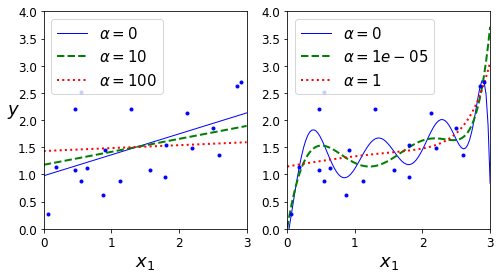

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler


def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

plt.show()

$\alpha$를 증가시킬수록 직선에 가까워지는 것을 볼 수 있습니다. 즉, 모델의 분산은 줄지만 편향은 커지게 됩니다. 

모델의 분삭과 편향 관련 자료:
https://bkshin.tistory.com/entry/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-12-%ED%8E%B8%ED%96%A5Bias%EC%99%80-%EB%B6%84%EC%82%B0Variance-Trade-off


**노트**: 향후 버전이 바뀌더라도 동일한 결과를 만들기 위해 사이킷런 0.21 버전의 기본값인 `max_iter=1000`과 `tol=1e-3`으로 지정합니다.

In [ ]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(penalty="l2", max_iter=1000, tol=1e-3, random_state=42)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.47012588])

## 라쏘 회귀 (Least absolute shrinkage and selection operator, Lasso)

라쏘 회귀는 선형 회귀의 또 다른 규제된 버전입니다. 릿지 회귀처럼 비용 함수에 규제항을 더하지만 L2-norm의 제곱을 2로 나눈 것 대신 가중치 벡터의 L1-norm을 사용합니다 [식 4-10]. 

**식 4-10: 라쏘 회귀의 비용 함수**

$
J(\boldsymbol{\theta}) = \text{MSE}(\boldsymbol{\theta}) + \alpha \sum\limits_{i=1}^{n}\left| \theta_i \right|
$

예제를 통해 라쏘 회귀에 대해서 알아보겠습니다.

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.803e+00, tolerance: 9.295e-04
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


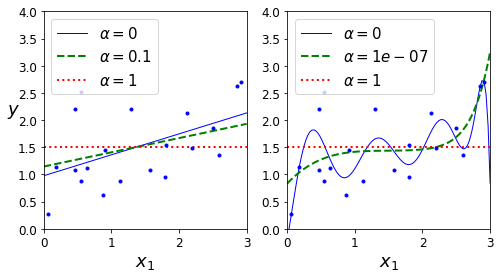

In [ ]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), random_state=42)

plt.show()

라쏘 회귀의 중요한 특징은 덜 중요한 특성의 가중치를 제거하려고 한다는 점입니다 (즉 가중치가 0이 됩니다). 예를 들어 위에 그래프에서 점선($\alpha = 10^{-7}$)은 2차방정식처럼 보이며 거의 선형적입니다. 차수가 높은 다항 특성의 가중치가 모두 0이 되었습니다. 다시말해 라쏘 회귀는 자동으로 특성 선택을 하고 희소 모델(sparse model)을 만듭니다 (즉, 0이 아닌 특성의 가중치가 적습니다.).  

In [ ]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

아래 예제를 통해 L1과 L2의 패널티 그리고 라쏘, 릿지 회귀 모델을 비교해 보겠습니다. 

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5

t1s = np.linspace(t1a, t1b, 500)
t2s = np.linspace(t2a, t2b, 500)
t1, t2 = np.meshgrid(t1s, t2s)
T = np.c_[t1.ravel(), t2.ravel()]
Xr = np.array([[1, 1], [1, -1], [1, 0.5]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]

print(Xr)
print(yr)

J = (1/len(Xr) * np.sum((T.dot(Xr.T) - yr.T)**2, axis=1)).reshape(t1.shape)

N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)

t_min_idx = np.unravel_index(np.argmin(J), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]

t_init = np.array([[0.25], [-1]])

[[ 1.   1. ]
 [ 1.  -1. ]
 [ 1.   0.5]]
[[2.5 ]
 [1.5 ]
 [2.25]]


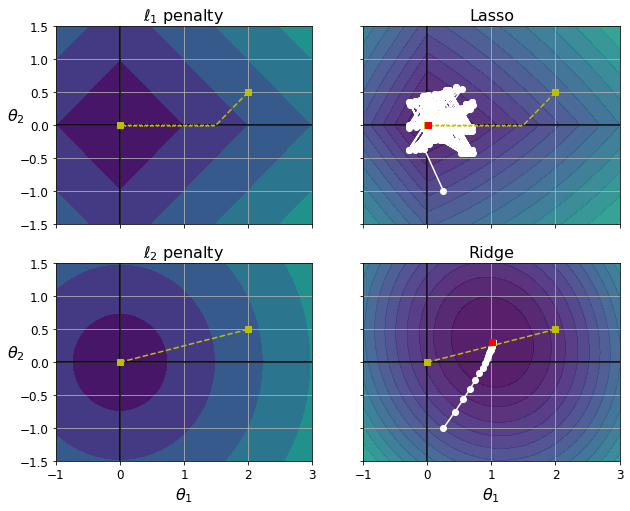

In [ ]:
def bgd_path(theta, X, y, l1, l2, core = 1, eta = 0.05, n_iterations = 200):
    path = [theta]
    for iteration in range(n_iterations):
        gradients = core * 2/len(X) * X.T.dot(X.dot(theta) - y) + l1 * np.sign(theta) + l2 * theta
        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10.1, 8))
for i, N, l1, l2, title in ((0, N1, 10., 0, "Lasso"), (1, N2, 0,  2., "Ridge")):
    JR = J + l1 * N1 + l2 * 0.5 * N2**2
    
    tr_min_idx = np.unravel_index(np.argmin(JR), JR.shape)
    t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]

    levelsJ=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(J) - np.min(J)) + np.min(J)
    levelsJR=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(JR) - np.min(JR)) + np.min(JR)
    levelsN=np.linspace(0, np.max(N), 10)
    
    path_J = bgd_path(t_init, Xr, yr, l1=0, l2=0)
    path_JR = bgd_path(t_init, Xr, yr, l1, l2)
    path_N = bgd_path(np.array([[2.0], [0.5]]), Xr, yr, np.sign(l1)/3, np.sign(l2), core=0)

    ax = axes[i, 0]
    ax.grid(True)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.contourf(t1, t2, N / 2., levels=levelsN)
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.set_title(r"$\ell_{}$ penalty".format(i + 1), fontsize=16)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$", fontsize=16)
    ax.set_ylabel(r"$\theta_2$", fontsize=16, rotation=0)

    ax = axes[i, 1]
    ax.grid(True)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.contourf(t1, t2, JR, levels=levelsJR, alpha=0.9)
    ax.plot(path_JR[:, 0], path_JR[:, 1], "w-o")
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.plot(t1r_min, t2r_min, "rs")
    ax.set_title(title, fontsize=16)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$", fontsize=16)

# save_fig("lasso_vs_ridge_plot")
plt.show()

두 축은 모델 파라미터 두개를 나타내고 등고선은 각기 다른 손실 함수를 나타냅니다. 왼쪽 위 그래프의 등고선은 L1 손실($|\boldsymbol{\theta_1}|+|\boldsymbol{\theta_2}|$)를 나타냅니다. 축에 가까워지면서 선형적으로 줄어 듭니다. 예를 들어 모델 파라미터를 $\boldsymbol{\theta_1}=2, \boldsymbol{\theta_2}=0.5$로 초기화하고 경사 하강법을 실행하면 두 파라미터가 동일하게 감소될 것입니다(노란 점섬). 따라서 $\boldsymbol{\theta_2}$가 먼저 0에 도달합니다 ($\boldsymbol{\theta_2}$가 시작할 때 0에 더 가깝기 때문입니다). 그다음 경사 하강법이 $\boldsymbol{\theta_1}=0$에 돌달할 때까지 축을 따라 내려갔습니다 (L1의 그레이디언트는 0에서 정의되지 않기 때문에 진동이 조금 있습니다. 이 지점에서 그레이디언트는 -1 또는 1입니다). 오른쪽 위 그래프 등고선 라쏘 손실함수를 나타냅니다. 하얀 작은 원이 경사 하강법이 $\boldsymbol{\theta_1}=0.25, \boldsymbol{\theta_2}=-1$로 초기화된 모델 파라미터를 최적화하는 과정을 보여줍니다. 여기에서도 $\boldsymbol{\theta_2}=0$으로 빠르게 줄어들고 그다음 축을 따라 진동하면서 전역 최적점(빨간 사각형)에 도달합니다. $\alpha$를 증가하면 전역 최적점이 노란 점선을 따라 왼쪽으로 이동합니다. $\alpha$를 감소하면 전역 최적점이 오른쪽으로 이동합니다. 아래 두개의 그래프도 동일하지만 L2페널티를 사용합니다. 왼쪽 아래 그래프에서 L2 손실은 원점에 가까울수록 줄어드는 것을 볼 수 있습니다. 따라서 경사 하강법이 원점까지 직선 경로를 따라 갑니다. 오른쪽 아래 그래프의 등고선은 릿지 회귀의 비용 함수를 나타냅니다(즉 L2손실을 더한  MSE 손실함수입니다). 라쏘와 다른점은 크게 두가지 입니다. 첫째 파라미터가 전역 최적점에 가까워질수록 그레이디언트가 작아집니다. 따라서 경사 하강법이 자동으로 느려지고 수렴에 도움이 됩니다 (진동이 없습니다). 둘째 $\alpha$를 증가시킬수록 최적의 파라미터(빨간 사각형)가 원점에 더 까까워집니다. 하지만 완전히 0이 되지는 않습니다.

* L1-norm

> L1-norm 크면 많은 가중치들이 0이 되거나 0에 가까워지게 하는 것에 좀 더 큰 비중을 두게 되는 반면, 훈련셋에서의 예측정확도는 상대적으로 덜 중요해진다. L1-norm이 작아질 수록 많은 가중치들이 0이 되거나 0에 가까워진다는 것을 기억하자. 이런 상황에서 $\alpha$가 크면 많은 가중치들이 0이 되거나 0에 가까워지게 하는 것에 좀 더 큰 비중을 두게 되는 반면, 훈련셋에서의 예측정확도는 상대적으로 덜 중요해진다. 왜냐하면 $\alpha$가 클 때는 전체값(MSE+penalty)이 L1-norm에 좌지우지되기 때문이다. L1-norm이 커지면 전체값이 커지므로 전체값을 최소가 되게 하기 위해서는 L1-norm을 작게 만드는 것이 우선순위가 된다. 반면 $\alpha$가 작으면 훈련셋에서의 예측정확도(MSE)가 작아지게 하는 것에 좀 더 큰 비중을 둔다. 전체값이 MSE에 의해 좌지우지 되기 때문이다. 따라서 $\alpha$가 너무 작으면 과대적합(복잡도가 너무 큼)이 되고, 너무 크면 과소적합(복잡도가 너무 작음)이 된다. 라쏘에서 구체적으로 $\alpha$의 값의 크기에 따라 어떤 일이 발생하는지 간단한 예를 들어보겠다. 

>  총 105개의 특성을 라쏘 회귀 모델을 만들기 위해 사용했다. $\alpha=1$로 설정했더니 105개의 가중치 중에서 101개가 0이 되면서 특성은 단 4개만 사용되었다. 훈련셋에서의 점수와 테스트셋에서의 점수를 보니 과소적합이었다. 따라서 복잡도를 높이기 위해서 $\alpha=0.0001$로 설정했더니 가중치 중에서 7개만 0이 되면서 94개의 특성이 사용되었다. 훈련셋과 테스트셋에서의 점수를 보니 훈련셋에서는 좋은데 테스트셋에서는 많이 떨어졌다. 즉, 과대적합이었다. 따라서 다시 복잡도를 낮추기 위해 $\alpha=0.1$을 사용했다. 105개의 가중치 중에서 72개가 0이 되면서 33개의 특성이 사용되었다. 훈련셋에서의 점수와 테스트셋에서의 점수가 모두 괜찮았다. 


## 엘라스틱넷 (Elastic net)

엘라스틱넷은 릿지 회귀와 라소회귀를 절충한 모델입니다. 규제항은 릿지와 회귀의 규제항을 단순히 더해서 사용하며, 혼합 정도는 혼합 비율 $r$을 사용해 조절합니다. $r=0$이면 엘라스틱넷은 릿지 회귀와 같고, $r=1$이면 라쏘 회귀와 같습니다 [식 4-12].  

**식 4-12: 엘라스틱넷 비용 함수**

$
J(\boldsymbol{\theta}) = \text{MSE}(\boldsymbol{\theta}) + r \alpha \sum\limits_{i=1}^{n}\left| \theta_i \right| + \dfrac{1 - r}{2} \alpha \sum\limits_{i=1}^{n}{{\theta_i}^2}
$

In [ ]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

데이터의 특성 수가 훈련 샘 수 보다 많거나 특성 몇 개가 강하게 연관되어 있을 때는 보통 라쏘가 문제를 일으키므로 라쏘보다는 엘라스틱넷을 선호합니다. 

## 조기 종료 (early stopping)

경사 하강법과 같은 반복적인 학습 알고리즘을 규제하는 아주 색다른 방식은 검증 에러가 최솟값에 도달하면 바로 훈련을 중지시키는 것입니다. 이를 조기 종료라고 합니다. 

예제를 통해 알아 보겠습니다.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

In [ ]:
from copy import deepcopy

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler())
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # 중지된 곳에서 다시 시작합니다
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = deepcopy(sgd_reg)

그래프를 그립니다:

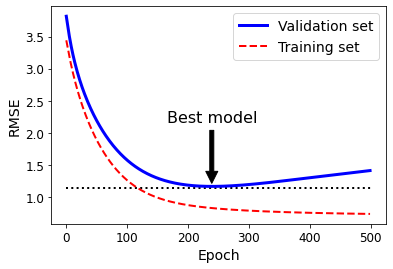

In [ ]:
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
# save_fig("early_stopping_plot")
plt.show()

Tip: 확률적 경사 하강법이나 미니배치 경사 하강법에서는 곡선이 그리 매끄럽지 않아 최솟값에 도달했는지 확인 하기 어려울 수 있습니다. 한 가지 해결책은 검증 에러가 일정 시간 동안 최솟값보다 클 때(모델이 더 나아지지 않는다고 확신이 들 때) 학습을 멈추고 검증 에러가 최소였을 때의 모델 파라미터로 되돌리는 것입니다.  

In [ ]:
best_epoch, best_model

(239,
 SGDRegressor(eta0=0.0005, learning_rate='constant', max_iter=1, penalty=None,
              random_state=42, tol=-inf, warm_start=True))